# データをざっくりと可視化し、分析の足がかりを得る。

## まとめ
0. train/testいずれにも欠損は無い。
1. trainデータとテストデータにはっきりした分布の違いは見受けられない。
2. 違和感のあるデータは以下の通り
   1. CustomerIdが一意的ではない。Surnameも異なる。([岡本さんのDiscussionの通り](https://www.kaggle.com/competitions/tdse-inclass-competition-0/discussion/509310))
   2. Ageに小数点以下が入っている。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib # matplotlibに日本語を表示するためのライブラリ
import seaborn as sns

In [37]:
# 自作のプロット用モジュールを読み込む
import sys
sys.path.append("../input/EDA_functions")
import plot_functions as my_plot
import data_search_functions as my_data_search

## 各種定数の定義

In [3]:
TARGET_COL_NAME = "Exited"

## データフレームの構造確認

In [4]:
# データを読み込む
train_df = pd.read_csv("../input/tdse-inclass-competition-0/train.csv")
test_df = pd.read_csv("../input/tdse-inclass-competition-0/test.csv")

In [5]:
# 読み込んだデータの確認。必要ならば型を変換する
print(train_df.dtypes)
train_df.head()

id                   int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                float64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard          float64
IsActiveMember     float64
EstimatedSalary    float64
Exited               int64
dtype: object


,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0,15674932,Okwudilichukwu,668,France,Male,33.0,3,0.00,2,1.0,0.0,181449.97,0
1,1,15749177,Okwudiliolisa,627,France,Male,33.0,1,0.00,2,1.0,1.0,49503.50,0
2,2,15694510,Hsueh,678,France,Male,40.0,10,0.00,2,1.0,0.0,184866.69,0
3,3,15741417,Kao,581,France,Male,34.0,2,148882.54,1,1.0,1.0,84560.88,0
4,4,15766172,Chiemenam,716,Spain,Male,33.0,5,0.00,2,1.0,1.0,15068.83,0


In [6]:
# Ageのunique valueを確認
train_df['Age'].unique()

array([33.  , 40.  , 34.  , 36.  , 30.  , 37.  , 43.  , 27.  , 71.  ,
       47.  , 25.  , 55.  , 61.  , 35.  , 41.  , 44.  , 26.  , 39.  ,
       31.  , 58.  , 49.  , 32.  , 50.  , 28.  , 45.  , 52.  , 29.  ,
       38.  , 54.  , 56.  , 46.  , 42.  , 64.  , 20.  , 21.  , 23.  ,
       48.  , 59.  , 51.  , 24.  , 53.  , 62.  , 57.  , 22.  , 66.  ,
       67.  , 19.  , 73.  , 60.  , 63.  , 65.  , 75.  , 68.  , 69.  ,
       76.  , 18.  , 70.  , 81.  , 74.  , 72.  , 77.  , 82.  , 79.  ,
       92.  , 80.  , 78.  , 83.  , 36.44, 85.  , 32.34, 84.  ])

In [7]:
# 型を変換するための辞書を作成
type_dict = {
    "id": int,
    "CustomerId": int,
    "Surname": str,
    "CreditScore": int,
    "Geography": str,
    "Gender": str,
    "Age": float, # intに変換しようとするとエラーが発生したため中身を確認したところ、float型になっていることがわかった
    "Tenure": int,
    "Balance": float,
    "NumOfProducts": int,
    "HasCrCard": int,
    "IsActiveMember": int,
    "EstimatedSalary": float,
    "Exited": int,
}

# カテゴリ変数か否かを判定する辞書を作成
is_category_dict = {
    "id": False,
    "CustomerId": False,
    "Surname": True,
    "CreditScore": False,
    "Geography": True,
    "Gender": True,
    "Age": False,
    "Tenure": False,
    "Balance": False,
    "NumOfProducts": False,
    "HasCrCard": True,
    "IsActiveMember": True,
    "EstimatedSalary": False,
    "Exited": True,
}

In [28]:
# 型を設定してデータを読み込む
train_df = pd.read_csv(
    "../input/tdse-inclass-competition-0/train.csv",
    dtype=type_dict,
)
print("len of train_df: ", format(len(train_df), ","))

test_df = pd.read_csv(
    "../input/tdse-inclass-competition-0/test.csv",
    dtype=type_dict,
    )
print("len of test_df: ", format(len(test_df), ","))

len of train_df:  165,034
len of test_df:  110,023


### 学習データの各カラムの基本統計量と欠損値の確認

In [9]:
# 各カラムの基本統計量を確認
train_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,165034.0000,1.650340e+05,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000,165034.000000
mean,82516.5000,1.569201e+07,656.454373,38.125888,5.020353,55478.086689,1.554455,0.753954,0.497770,112574.822734,0.211599
std,47641.3565,7.139782e+04,80.103340,8.867205,2.806159,62817.663278,0.547154,0.430707,0.499997,50292.865585,0.408443
min,0.0000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000,0.000000
25%,41258.2500,1.563314e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74637.570000,0.000000
50%,82516.5000,1.569017e+07,659.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117948.000000,0.000000
75%,123774.7500,1.575682e+07,710.000000,42.000000,7.000000,119939.517500,2.000000,1.000000,1.000000,155152.467500,0.000000
max,165033.0000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000,1.000000


In [10]:
# 欠損値の確認 (欠損値がある場合は、その数を表示する) → 欠損値はない
train_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

### テストデータの各カラムの基本統計量と欠損値の確認

In [12]:
# 各カラムの基本統計量を確認
test_df.describe()

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,110023.000000,1.100230e+05,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000,110023.000000
mean,220045.000000,1.569210e+07,656.530789,38.122205,4.996637,55333.611354,1.553321,0.753043,0.495233,112315.147765
std,31761.048671,7.168499e+04,80.315415,8.861550,2.806148,62788.519675,0.544714,0.431244,0.499980,50277.048244
min,165034.000000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.000000,0.000000,11.580000
25%,192539.500000,1.563286e+07,597.000000,32.000000,3.000000,0.000000,1.000000,1.000000,0.000000,74440.325000
50%,220045.000000,1.569018e+07,660.000000,37.000000,5.000000,0.000000,2.000000,1.000000,0.000000,117832.230000
75%,247550.500000,1.575693e+07,710.000000,42.000000,7.000000,120145.605000,2.000000,1.000000,1.000000,154631.350000
max,275056.000000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.000000,1.000000,199992.480000


In [13]:
# 欠損値の確認 (欠損値がある場合は、その数を表示する) → 欠損値はない
test_df.isnull().sum()

id                 0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
dtype: int64

## CustomerIdの重複について

In [26]:
# 学習データのCustomerIDとテストデータのCustomerIDを比較する。
train_customer_id = train_df["CustomerId"].values
test_customer_id = test_df["CustomerId"].values
train_customer_id_unique = train_df["CustomerId"].unique()
test_customer_id_unique = test_df["CustomerId"].unique()
# customer_idの重複を確認する → uniqueをとるだけでlenが8分の1になることがわかる
print("len of train_customer_id:", format(len(train_customer_id), ","))
print("len of train_customer_id_unique:", format(len(train_customer_id_unique), ","))
print("len of test_customer_id:", format(len(test_customer_id), ","))
print("len of test_customer_id_unique:", format(len(test_customer_id_unique), ","))
# 2つのリストの対称差を取得する
customer_id_diff_set = set(train_customer_id) ^ set(test_customer_id)
# 差分の確認
print("len of train_customer_id ^ test_customer_id:", format(len(customer_id_diff_set), ","))
# min, maxを確認する
print("train_customer_id - min:", format(min(train_customer_id), ","))
print("train_customer_id - max:", format(max(train_customer_id), ","))
print("test_customer_id - min:", format(min(test_customer_id), ","))
print("test_customer_id - max:", format(max(test_customer_id), ","))

len of train_customer_id: 165,034
len of train_customer_id_unique: 23,221
len of test_customer_id: 110,023
len of test_customer_id_unique: 19,698
len of train_customer_id ^ test_customer_id: 14,029
train_customer_id - min: 15,565,701
train_customer_id - max: 15,815,690
test_customer_id - min: 15,565,701
test_customer_id - max: 15,815,690


In [39]:
# 学習データの重複行を表示
duplicate_train_df = my_data_search.find_duplicates(train_df, 'CustomerId')
print("Train Data Duplicates:\n", duplicate_train_df)
duplicate_train_df.to_csv("duplicate_train_data.csv", index=False)

# テストデータの重複行を表示
duplicate_test_df = my_data_search.find_duplicates(test_df, 'CustomerId')
print("Test Data Duplicates:\n", duplicate_test_df)
duplicate_test_df.to_csv("duplicate_test_data.csv", index=False)

Train Data Duplicates:
             id  CustomerId   Surname  CreditScore Geography  Gender   Age  \
87277    87277    15565701     Bruno          846     Spain    Male  49.0   
140882  140882    15565701   Chineze          705    France    Male  32.0   
160702  160702    15565701     Ferri          698    France  Female  39.0   
93734    93734    15565706  McGregor          564    France    Male  34.0   
8288      8288    15565706  Akobundu          663     Spain    Male  35.0   
...        ...         ...       ...          ...       ...     ...   ...   
123836  123836    15815690  Akabueze          614     Spain  Female  40.0   
46972    46972    15815690      Tuan          651   Germany  Female  33.0   
74247    74247    15815690     Ch'iu          661   Germany    Male  51.0   
124621  124621    15815690      Teng          565    France    Male  42.0   
43859    43859    15815690  Akabueze          740     Spain  Female  35.0   

        Tenure    Balance  NumOfProducts  HasCrCard

## 各カラムの分布を確認

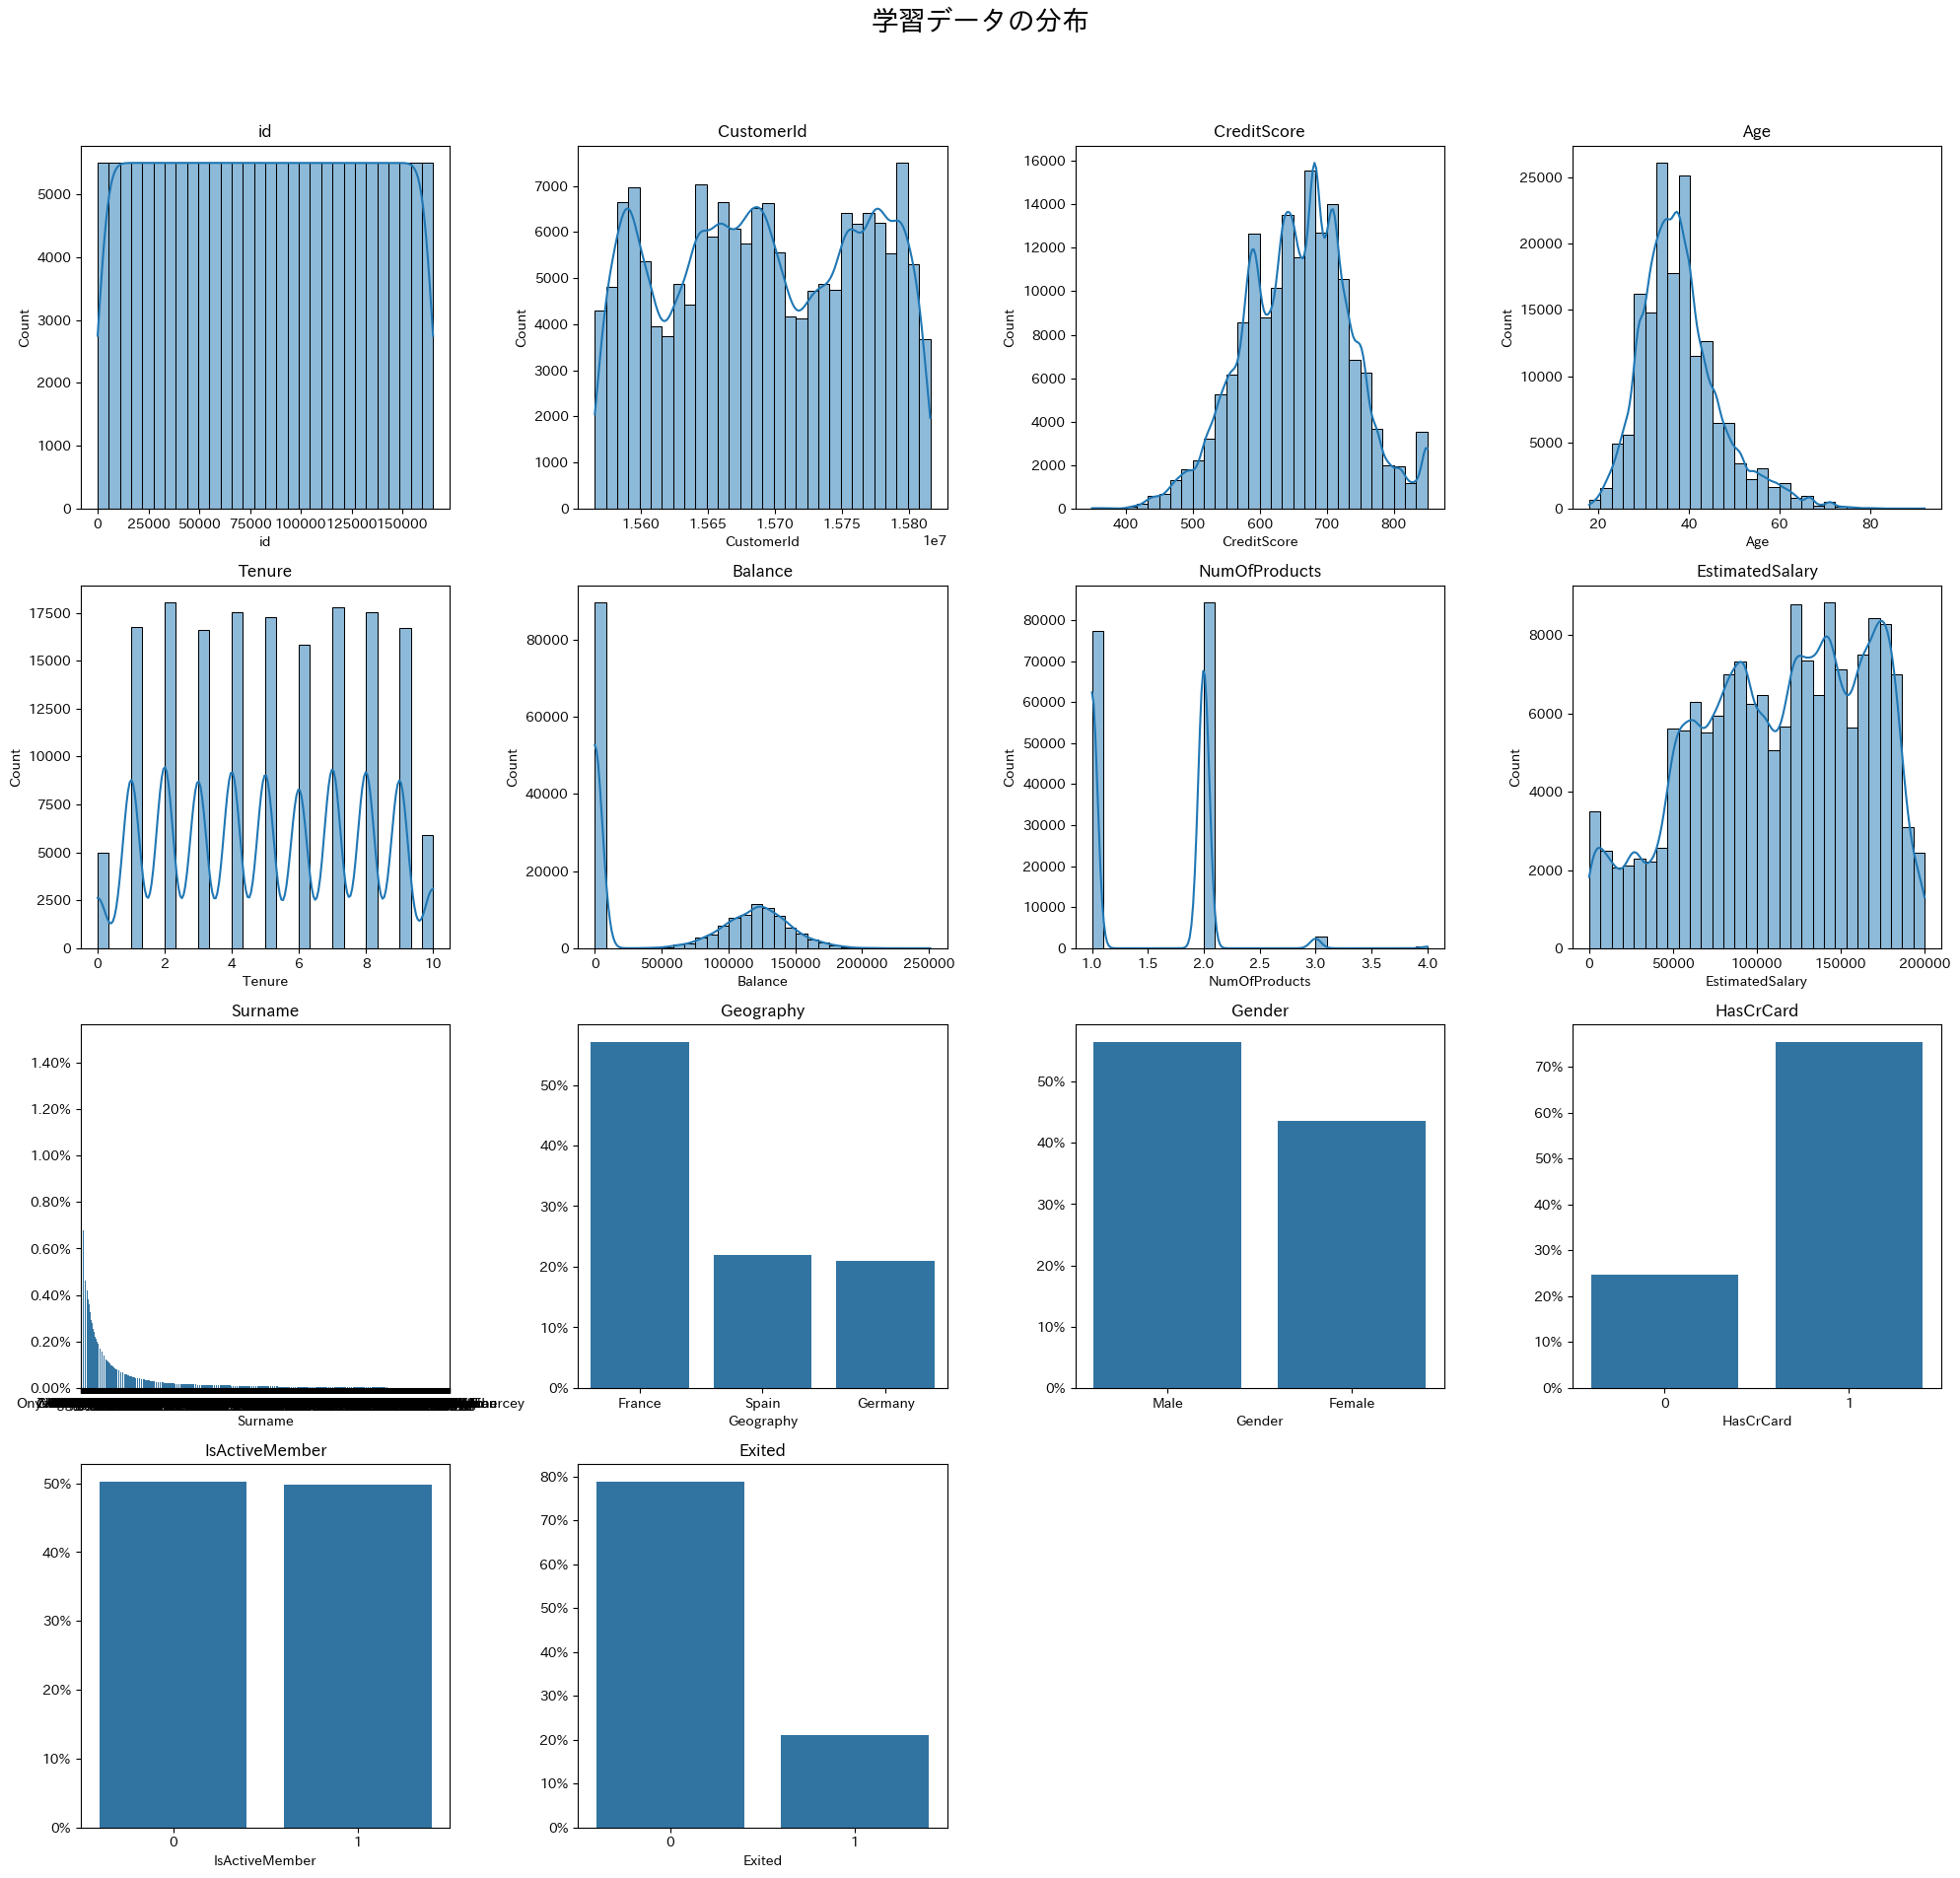

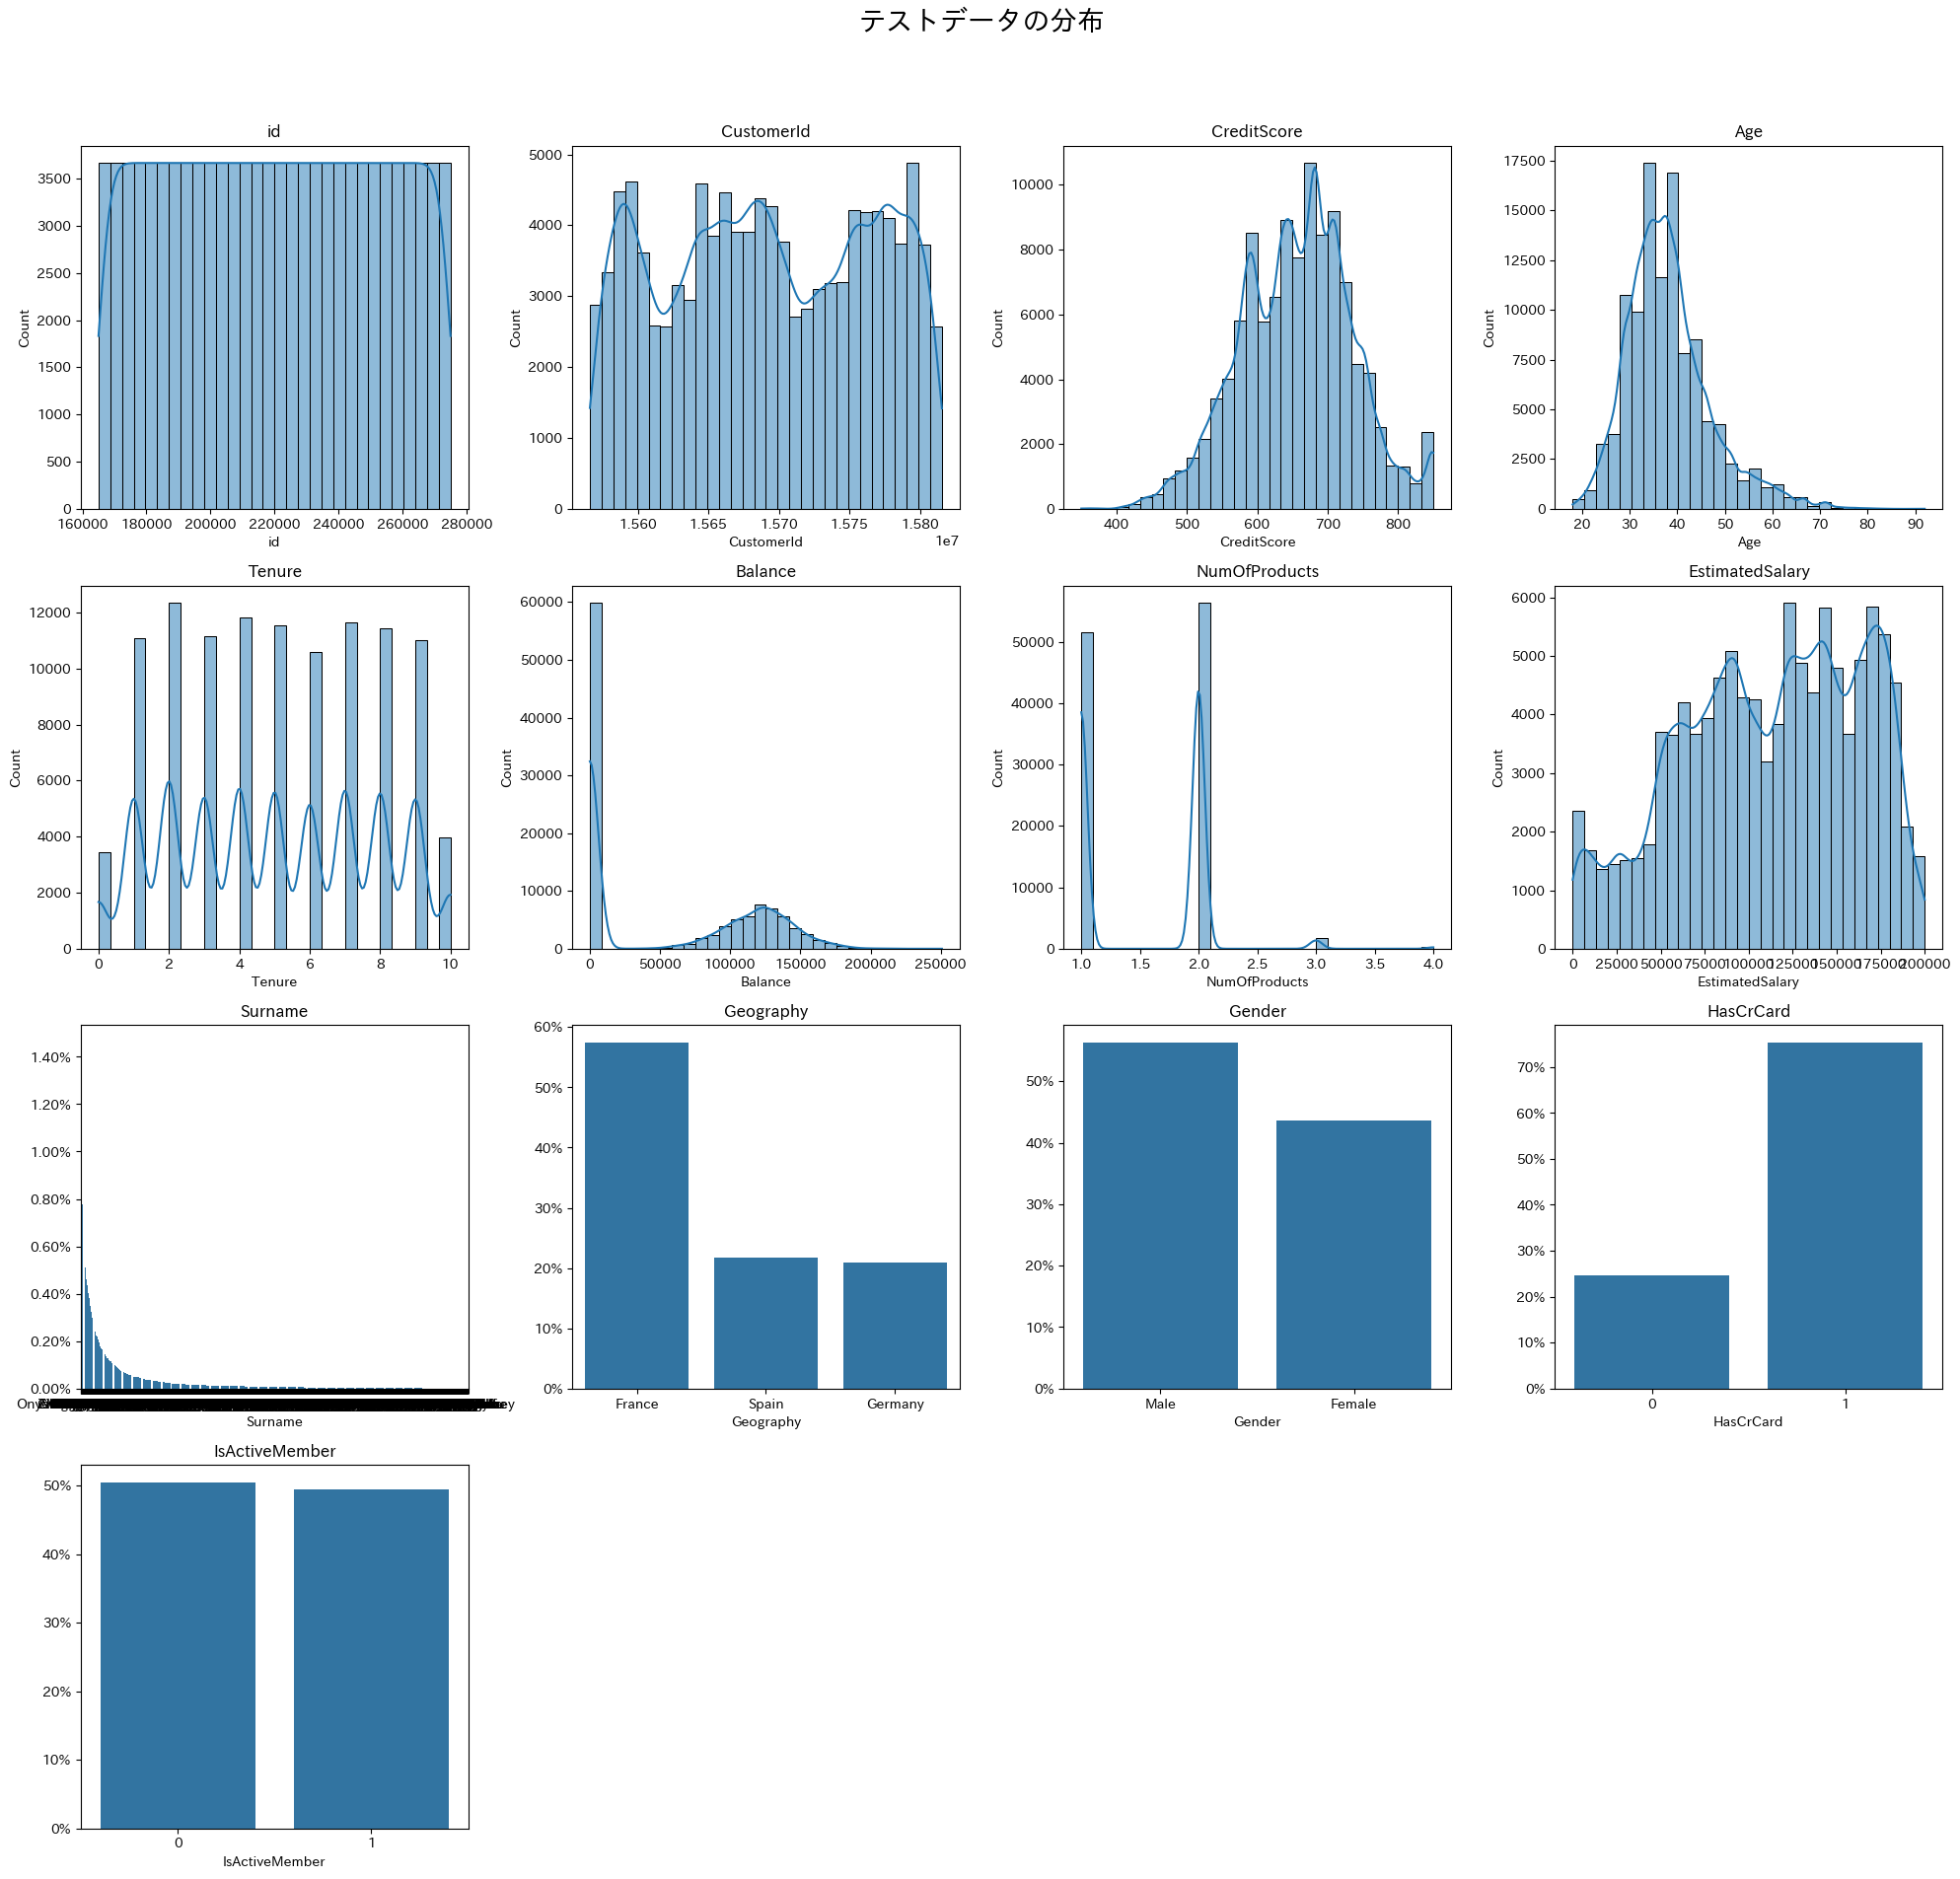

In [11]:
# 学習データの分布を確認
my_plot.plot_distributions(
    train_df,
    is_category_dict,
    title="学習データの分布",
)

# テストデータの分布を確認
my_plot.plot_distributions(
    test_df,
    {
        key: value
        for key, value in is_category_dict.items()
        if key != TARGET_COL_NAME
    },
    title="テストデータの分布",
)
